In [122]:
from unet_extras.zf_unet_224_model import ZF_UNET_224, dice_coef_loss, dice_coef
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [126]:
K.clear_session()

## Global Params


In [123]:
DATA_DIR = '../clean_data'

NUM_SAMPLES_TRAIN = 776

TARGET_SIZE = (224, 224)
BATCH_SIZE = 16

# Unet for General Mass Detection

In [118]:
# use same seed for images and masks
seed = 109

im_fit_datagen = ImageDataGenerator()
im_fit_generator = im_fit_datagen.flow_from_directory(
    f'{DATA_DIR}/mass/train/images',
    target_size=TARGET_SIZE,
    batch_size=NUM_SAMPLES_TRAIN,
    class_mode=None,
    seed=seed
)

mask_fit_datagen = ImageDataGenerator()
mask_fit_generator = mask_fit_datagen.flow_from_directory(
    f'{DATA_DIR}/mass/train/masks',
    target_size=TARGET_SIZE,
    batch_size=NUM_SAMPLES_TRAIN,
    class_mode=None,
    seed=seed,
    color_mode='grayscale'
)

images = next(im_fit_generator)
masks = next(mask_fit_generator)

Found 776 images belonging to 1 classes.
Found 776 images belonging to 1 classes.


In [63]:
# we create two instances with the same arguments
data_gen_args = dict(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=90,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    validation_split=.2,
    rescale=1./255,
)

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1
image_datagen.fit(images, augment=True, seed=seed)
mask_datagen.fit(masks, augment=True, seed=seed)

image_train_generator = image_datagen.flow_from_directory(
    f'{DATA_DIR}/mass/train/images',
    class_mode=None,
    seed=seed,
    subset='training',
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
)

image_val_generator = image_datagen.flow_from_directory(
    f'{DATA_DIR}/mass/train/images',
    class_mode=None,
    seed=seed,
    subset='validation',
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
)

mask_train_generator = mask_datagen.flow_from_directory(
    f'{DATA_DIR}/mass/train/masks',
    class_mode=None,
    seed=seed,
    subset='training',
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='grayscale'
)

mask_val_generator = mask_datagen.flow_from_directory(
    f'{DATA_DIR}/mass/train/masks',
    class_mode=None,
    seed=seed,
    subset='validation',
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='grayscale'
)

# combine generators into one which yields image and masks
train_generator = zip(image_train_generator, mask_train_generator)
val_generator = zip(image_val_generator, mask_val_generator)

Found 621 images belonging to 1 classes.
Found 155 images belonging to 1 classes.
Found 621 images belonging to 1 classes.
Found 155 images belonging to 1 classes.


In [64]:
data_generator_image_test = ImageDataGenerator(rescale=1./255)
data_generator_mask_test = ImageDataGenerator(rescale=1./255)

image_test_generator = data_generator_image_test.flow_from_directory(
    f'{DATA_DIR}/mass/test/images',
    class_mode=None,
    seed=seed,
    target_size=TARGET_SIZE,
    color_mode='rgb'
)

mask_test_generator = data_generator_mask_test.flow_from_directory(
    f'{DATA_DIR}/mass/test/masks',
    class_mode=None,
    seed=seed,
    target_size=TARGET_SIZE
)

test_generator = zip(image_test_generator, mask_test_generator)

In [128]:
model.layers[39].name

'conv2d_104'

In [147]:
model = ZF_UNET_224(weights='generator')
optim = Adam()

for i in range(44):
    model.layers[i].trainable = False

model.compile(optimizer=optim, loss=dice_coef_loss, metrics=[dice_coef])

In [ ]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=150,
    epochs=30,
    validation_data=val_generator,
    validation_steps=30
)

Epoch 1/30
150/150 [==============================] - 94s 628ms/step - loss: 0.1627 - dice_coef: -0.1627 - val_loss: 1.7826e-05 - val_dice_coef: -1.7826e-05
Epoch 2/30
150/150 [==============================] - 87s 578ms/step - loss: 0.1665 - dice_coef: -0.1665 - val_loss: 1.7830e-05 - val_dice_coef: -1.7830e-05
Epoch 3/30
 93/150 [=================>............] - ETA: 30s - loss: 0.1657 - dice_coef: -0.1657

In [139]:
# get batch of test images for plotting
im, mask = next(test_generator)

pred = model.predict(im, steps=len(im), verbose = 1)

32/32 [==============================] - 15s 479ms/step


In [140]:
def show_predictions(ims, masks, preds, index=0):
    fig, ax = plt.subplots(1, 3, figsize=[8, 4])
    
    ax[0].imshow(ims[index])
    ax[1].imshow(masks[index])
    ax[2].imshow(preds[index].reshape(224, 224), cmap='gray')
    
    ax[0].set_title('Original image')
    ax[1].set_title('True mask')
    ax[2].set_title('Predicted mask')

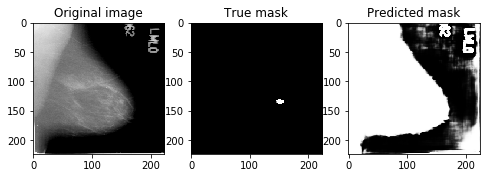

In [146]:
show_predictions(im, mask, pred, 0)

# Unet for Malignant Mass Detection

In this case, we want our UNET to only give masks for malignant masses. To do this, we will train using all black masses for benign samples and normal masks for malignant ones.

## Data Prep

We will do most of the same dataprep as above.

In [ ]:
# first, get the masks in memory so that we can fit the image augmentation
mask_bb_fit_datagen = ImageDataGenerator()
mask_bb_fit_generator = mask_bb_fit_datagen.flow_from_directory(
    f'{DATA_DIR}/mass/train/mask_blackbox',
    target_size=TARGET_SIZE,
    batch_size=NUM_SAMPLES,
    class_mode=None,
    seed=seed,
    color_mode='grayscale'
)

masks_bb = next(mask_bb_fit_generator)

In [ ]:
# recreate our generators to ensure seed hasn't changed (using same args from above)
image_bb_datagen = ImageDataGenerator(**data_gen_args)
mask_bb_datagen = ImageDataGenerator(**data_gen_args)

# use the same seed for masks and images throughout so they line up correctly
seed = 1
image_bb_datagen.fit(images, augment=True, seed=seed)
mask_bb_datagen.fit(masks_bb, augment=True, seed=seed)

image_bb_train_generator = image_bb_datagen.flow_from_directory(
    f'{DATA_DIR}/mass/train/images',
    class_mode=None,
    seed=seed,
    subset='training',
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
)

image_bb_val_generator = image_datagen.flow_from_directory(
    f'{DATA_DIR}/mass/train/images',
    class_mode=None,
    seed=seed,
    subset='validation',
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
)

mask_bb_train_generator = mask_bb_datagen.flow_from_directory(
    f'{DATA_DIR}/mass/train/mask_blackbox',
    class_mode=None,
    seed=seed,
    subset='training',
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='grayscale'
)

mask_bb_val_generator = mask_bb_datagen.flow_from_directory(
    f'{DATA_DIR}/mass/train/mask_blackbox',
    class_mode=None,
    seed=seed,
    subset='validation',
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='grayscale'
)

# combine generators into one which yields image and masks
train_bb_generator = zip(image_bb_train_generator, mask_bb_train_generator)
val_bb_generator = zip(image_bb_val_generator, mask_bb_val_generator)

### Recompile and Fit Model

In [ ]:
model = ZF_UNET_224(weights='generator')

for i in range(len(model.layers) - 6):
    model.layers[i].trainable = False

model.compile(optimizer=Adam(), loss=dice_coef_loss, metrics=[dice_coef])

model.fit_generator(
    train_generator,
    steps_per_epoch=1500,
    epochs=10,
    validation_data=val_generator,
    validation_steps=150
)

### Set up testing data

In [ ]:
# again need to recreate to ensure correct alignment
data_generator_image_bb_test = ImageDataGenerator(rescale=1./255)
data_generator_mask_bb_test = ImageDataGenerator(rescale=1./255)

image_bb_test_generator = data_generator_image_bb_test.flow_from_directory(
    f'{DATA_DIR}/mass/test/images',
    class_mode=None,
    seed=seed,
    target_size=TARGET_SIZE,
    color_mode='rgb'
)

mask_bb_test_generator = data_generator_mask_bb_test.flow_from_directory(
    f'{DATA_DIR}/mass/test/mask_blackbox',
    class_mode=None,
    seed=seed,
    target_size=TARGET_SIZE
)

test_bb_generator = zip(image_bb_test_generator, mask_bb_test_generator)